Take a copy of this notebook for each model you will implement.

This is the initial notebook — any changes will be made here before starting model building to ensure consistency across all notebooks.

**Key Consistency Tips**

* Standardized Headings: Use identical section names across all notebooks.

* Code Comments: Explain non-trivial steps (e.g., "Handling class imbalance with SMOTE").

* Version Control: Add a requirements.txt in the repo for dependency management. مش لازم

* Outputs: Save all plots/figures to a /results folder with consistent naming (e.g., XGBoost_SHAP.png).
اعتقد هتبقى كويسة عشان واحنا بنعمل البيبر ما نقعدش ناخد سكرينات


* Reproducibility: Set global random seeds (e.g., np.random.seed(42)).

# **Imports**

In [1]:
%%capture
!pip install -q lime shap PyALE

In [2]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import kagglehub, warnings
from sklearn.model_selection import train_test_split, learning_curve, ValidationCurveDisplay
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, RocCurveDisplay, auc, PrecisionRecallDisplay
from sklearn.inspection import PartialDependenceDisplay
import shap
from shap import Explanation, plots
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import plot_tree

warnings.filterwarnings('ignore')

# **Utils**

In [3]:
def our_confusion_matrix(model, name='Model'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
    ConfusionMatrixDisplay.from_estimator(model, X_train, y_train, cmap="Oranges", ax=ax1)
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap="Oranges", ax=ax2)
    plt.title(f"{name} Confusion Matrix")

def our_roc(model, name="Model"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    roc1 = RocCurveDisplay.from_estimator(
    model, X_train, y_train,
    name=name, ax=ax1,
    color="orange"
    )
    roc2 = RocCurveDisplay.from_estimator(
        model, X_test, y_test,
        name=name, ax=ax2,
        color="orange"
    )
    ax1.fill_between(roc1.fpr, roc1.tpr, alpha=0.4, color="orange")
    ax2.fill_between(roc2.fpr, roc2.tpr, alpha=0.4, color="orange")
    ax1.set_title(f"{name} Training ROC Curve", fontsize=16)
    ax2.set_title(f"{name} Testing ROC Curve", fontsize=16)
    for ax in [ax1, ax2]:
        ax.grid(alpha=0.5)

def our_learning_curve(model, name='Model'):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=5, scoring='accuracy',
        train_sizes=np.linspace(0.1, 1.0, 10), random_state=0
    )

    plt.figure(figsize=(13, 8))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color="mediumseagreen", label="Training score")
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color="royalblue", label="Cross-validation score")
    plt.title(f"{name} Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid(alpha=0.5)

def our_prc(model, name="Model"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 13))
    train_disp = PrecisionRecallDisplay.from_estimator(model, X_train, y_train, ax=ax1, color='orange')
    test_disp = PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=ax2, color='orange')
    ax1.set_title(f"{name} Precision-Recall Curve - Train")
    ax2.set_title(f"{name} Precision-Recall Curve - Test")
    ax1.fill_between(train_disp.recall, train_disp.precision, alpha=0.4, color='orange')
    ax2.fill_between(test_disp.recall, test_disp.precision, alpha=0.4, color='orange')

# **Load Processed Dat**a

In [4]:
path = kagglehub.dataset_download('mohamedhassan77/xai-project-processed-data')
df = pd.read_csv(f"{path}/combined_adasyn_train_test.csv")
df

Age  BusinessTravel  DailyRate  Department  DistanceFromHome  Education  \
0      31               2       1062           1                24          3   
1      50               2        328           1                 1          3   
2      46               2        717           1                13          4   
3      44               2        170           1                 1          4   
4      26               1       1479           1                 1          3   
...   ...             ...        ...         ...               ...        ...   
2042   56               2       1162           1                24          2   
2043   46               2        669           2                 9          2   
2044   30               2       1240           0                 9          3   
2045   31               2        741           1                 2          4   
2046   31               2        670           1                26          1   

      EducationField  EnvironmentSatisfaction  Gender  HourlyRate  ...  \
0                  3                        3       0          96  ...   
1                  3                        3       1          86  ...   
2                  1                        3       1          34  ...   
3                  1                        2       1          78  ...   
4                  1                        3       0          84  ...   
...              ...                      ...     ...         ...  ...   
2042               1                        1       1          97  ...   
2043               3                        3       1          64  ...   
2044               0                        3       1          48  ...   
2045               1                        2       1          69  ...   
2046               1                        1       1          31  ...   

      WorkLifeBalance  YearsAtCompany  YearsInCurrentRole  \
0                   3            10.0                   9   
1                   2             3.0                   2   
2                   3            10.0                   7   
3                   3             2.0                   0   
4                   1             6.0                   5   
...               ...             ...                 ...   
2042                3             4.0                   2   
2043                3             9.0                   8   
2044                1            11.0                   9   
2045                4             5.0                   2   
2046                2             5.0                   2   

      YearsSinceLastPromotion  YearsWithCurrManager  promotion_velocity  \
0                           1                     8            9.999900   
1                           0                     2       300000.000000   
2                           0                     9      1000000.000000   
3                           2                     2            0.999995   
4                           1                     4            5.999940   
...                       ...                   ...                 ...   
2042                        1                     0            3.999960   
2043                        4                     7            2.249994   
2044                        4                     7            2.749993   
2045                        0                     3       500000.000000   
2046                        4                     3            1.249997   

      workload_score  compensation_ratio  Attrition    Set  
0                  1            1.019760          0  Train  
1                  2            1.281918          0  Train  
2                  1            0.832635          0  Train  
3                  1            0.753443          0  Train  
4                  3            1.007878          0  Train  
...              ...                 ...        ...    ...  
2042               1            0.898732          1   Test  
2043               1  

In [5]:
train_df = df[df['Set'] == 'Train'].drop(columns=['Set'])
test_df = df[df['Set'] == 'Test'].drop(columns=['Set'])

X_train = train_df.drop(columns=['Attrition'])
y_train = train_df['Attrition']

X_test = test_df.drop(columns=['Attrition'])
y_test = test_df['Attrition']

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

X_train: (1589, 33) y_train: (1589,)
X_test: (458, 33) y_test: (458,)


# **Modeling**

In [6]:
AdaBoostClassifier().fit(X_train, y_train).score(X_test, y_test)

0.8078602620087336

In [7]:
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)
ada.score(X_train, y_train), ada.score(X_test, y_test)

(0.8892385147891756, 0.8078602620087336)

<Figure size 2100x1300 with 0 Axes>

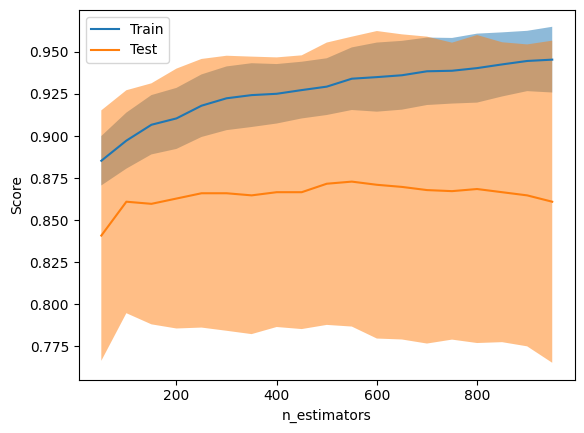

In [8]:
from sklearn.model_selection import ValidationCurveDisplay, validation_curve

param_name, param_range = "n_estimators", np.arange(50, 1000, 50)
train_scores, test_scores = validation_curve(
    ada, X_train, y_train, param_name=param_name, param_range=param_range
)
plt.figure(figsize=(21, 13))
display = ValidationCurveDisplay(
    param_name=param_name, param_range=param_range,
    train_scores=train_scores, test_scores=test_scores, score_name="Score"
)
display.plot()

The model shows very high variance on the test dataset. while in training it is much more consistent

# **Model Evaluation**

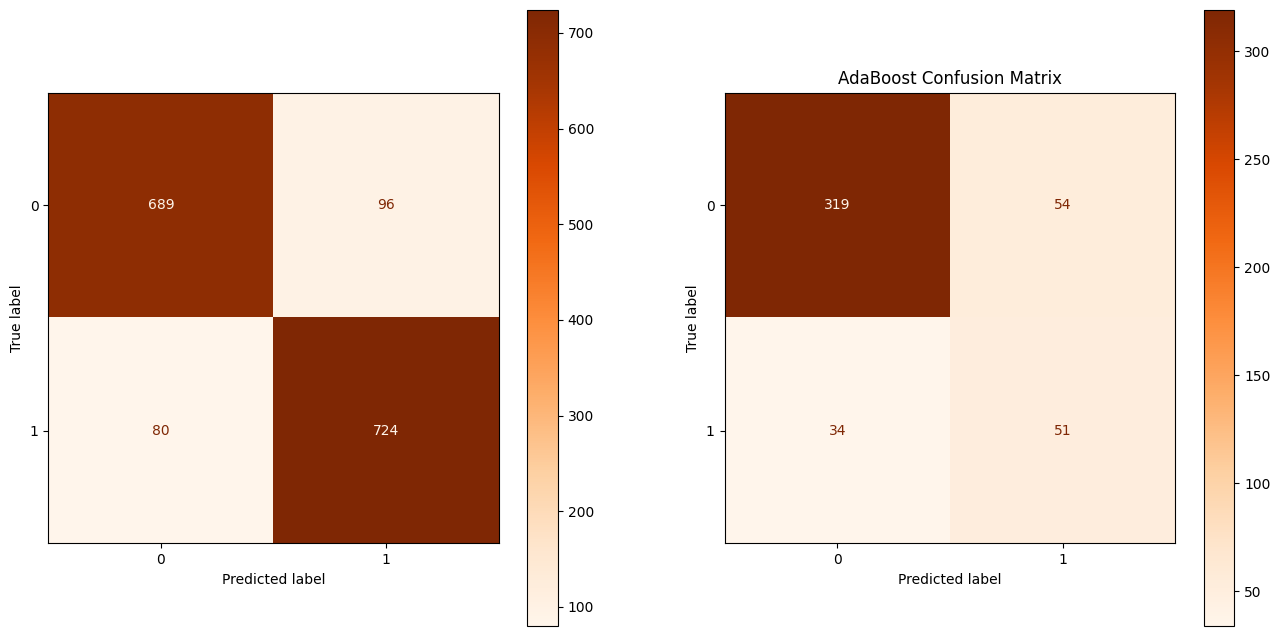

In [9]:
our_confusion_matrix(ada, "AdaBoost")

AdaBoost struggles with identifying class 1 on the test data

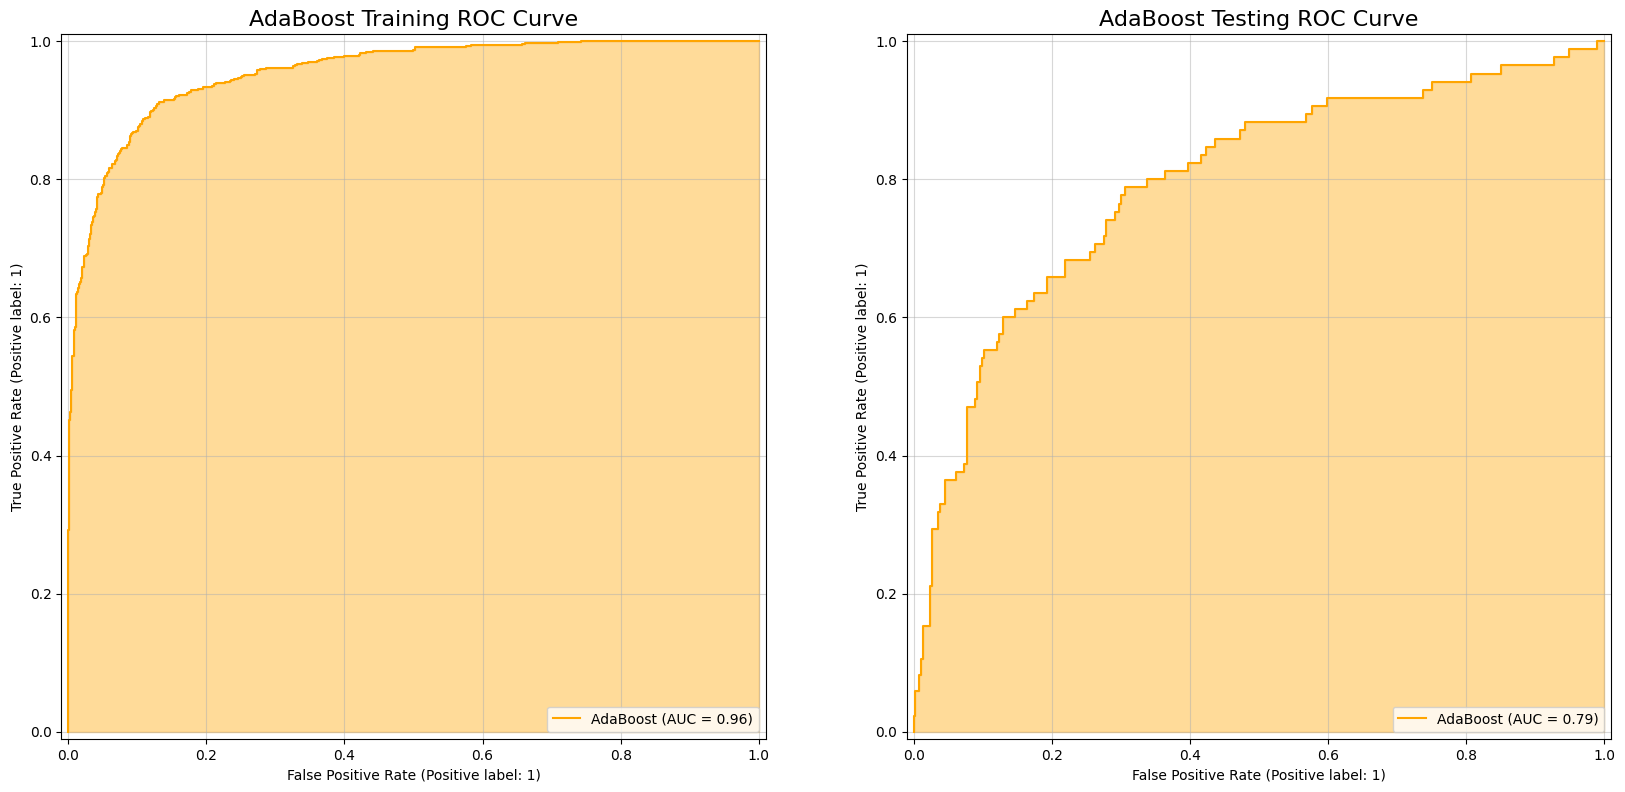

In [10]:
our_roc(ada, "AdaBoost")

The model shows high area under the curve AUC on the training data while it shows low AUC on the test data. This implies overfitting

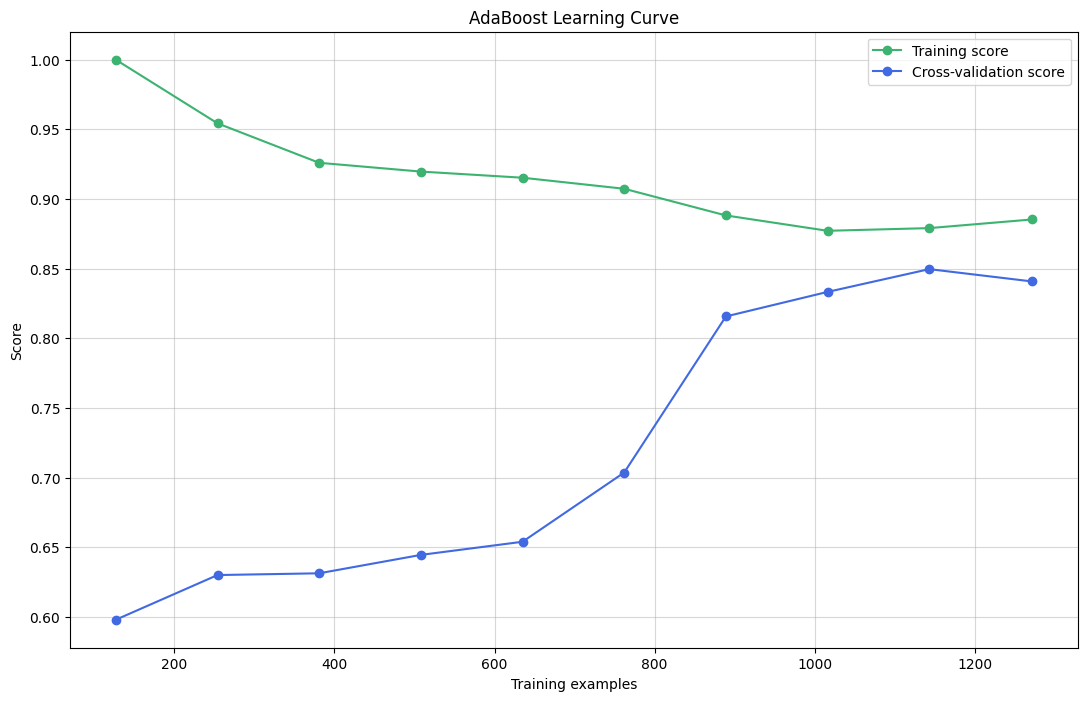

In [11]:
our_learning_curve(ada, "AdaBoost")

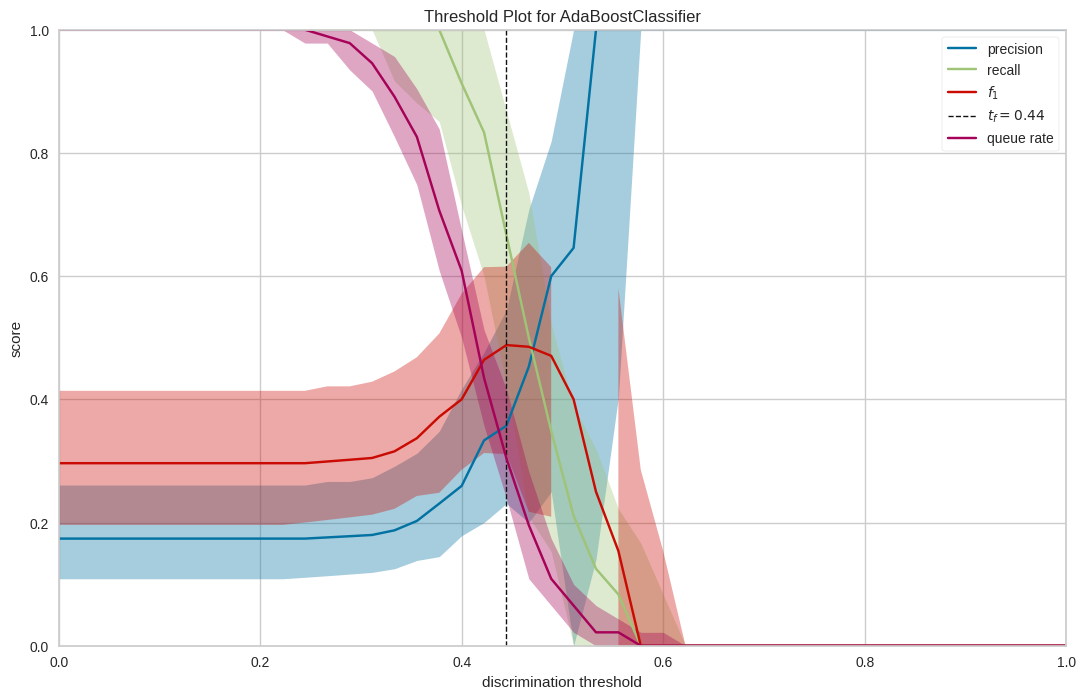

<Axes: title={'center': 'Threshold Plot for AdaBoostClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [12]:
from yellowbrick.classifier import DiscriminationThreshold
plt.figure(figsize=(13, 8))
DiscriminationThreshold(ada).fit(X_test, y_test).poof()

# **Explainability Techniques**

## Feature Importance (Model-Specific)

[Text(3, 0, '0.000'),
 Text(3, 0, '0.000'),
 Text(3, 0, '0.000'),
 Text(3, 0, '0.000'),
 Text(3, 0, '0.000'),
 Text(3, 0, '0.000'),
 Text(3, 0, '0.000'),
 Text(3, 0, '0.000'),
 Text(3, 0, '0.000'),
 Text(3, 0, '0.000'),
 Text(3, 0, '0.014'),
 Text(3, 0, '0.018'),
 Text(3, 0, '0.019'),
 Text(3, 0, '0.019'),
 Text(3, 0, '0.020'),
 Text(3, 0, '0.020'),
 Text(3, 0, '0.025'),
 Text(3, 0, '0.026'),
 Text(3, 0, '0.030'),
 Text(3, 0, '0.030'),
 Text(3, 0, '0.040'),
 Text(3, 0, '0.046'),
 Text(3, 0, '0.048'),
 Text(3, 0, '0.049'),
 Text(3, 0, '0.050'),
 Text(3, 0, '0.051'),
 Text(3, 0, '0.059'),
 Text(3, 0, '0.062'),
 Text(3, 0, '0.063'),
 Text(3, 0, '0.068'),
 Text(3, 0, '0.074'),
 Text(3, 0, '0.078'),
 Text(3, 0, '0.093')]

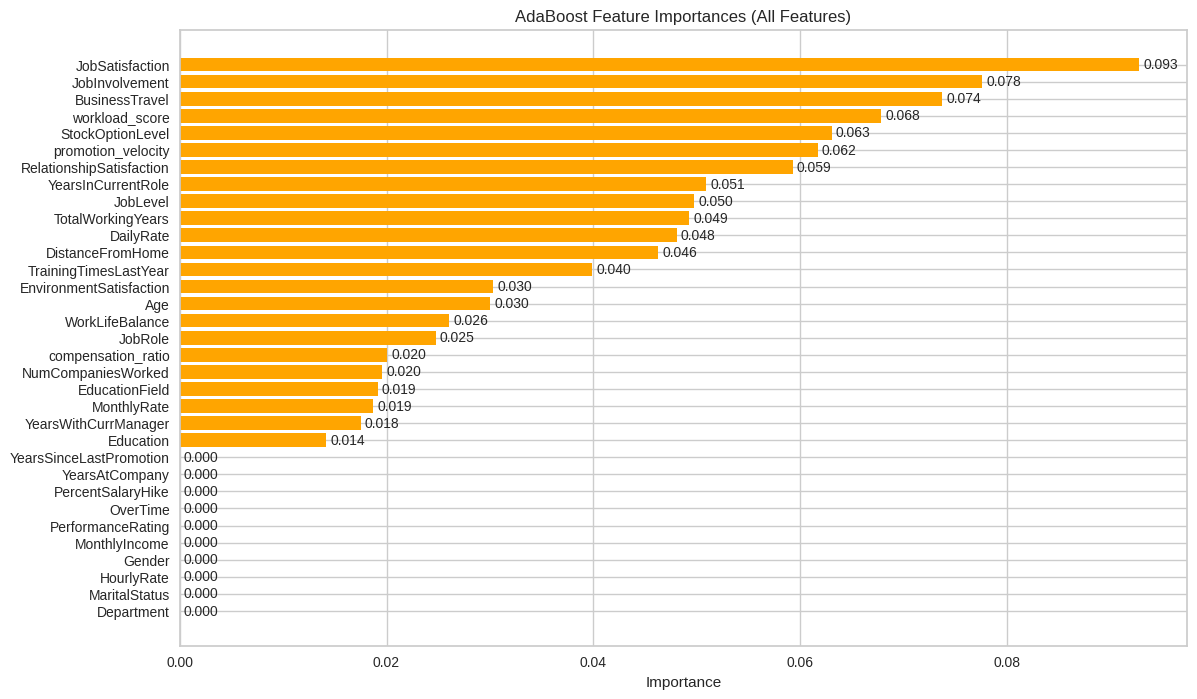

In [13]:
importances = ada.feature_importances_
feat_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(13, 8))
ax = plt.gca()
bars = ax.barh(X_train.columns[feat_idx][::-1], importances[feat_idx][::-1], color="orange")
ax.set_xlabel("Importance")
ax.set_title("AdaBoost Feature Importances (All Features)")
ax.bar_label(bars, fmt="%.3f", padding=3, fontsize=10)

- The model prioritizes employee related metrics (satisfaction, workload, engagement)

-  Focus on improving job satisfaction, managing workloads, and aligning stock incentives for better results.

## Partial Dependence Plots

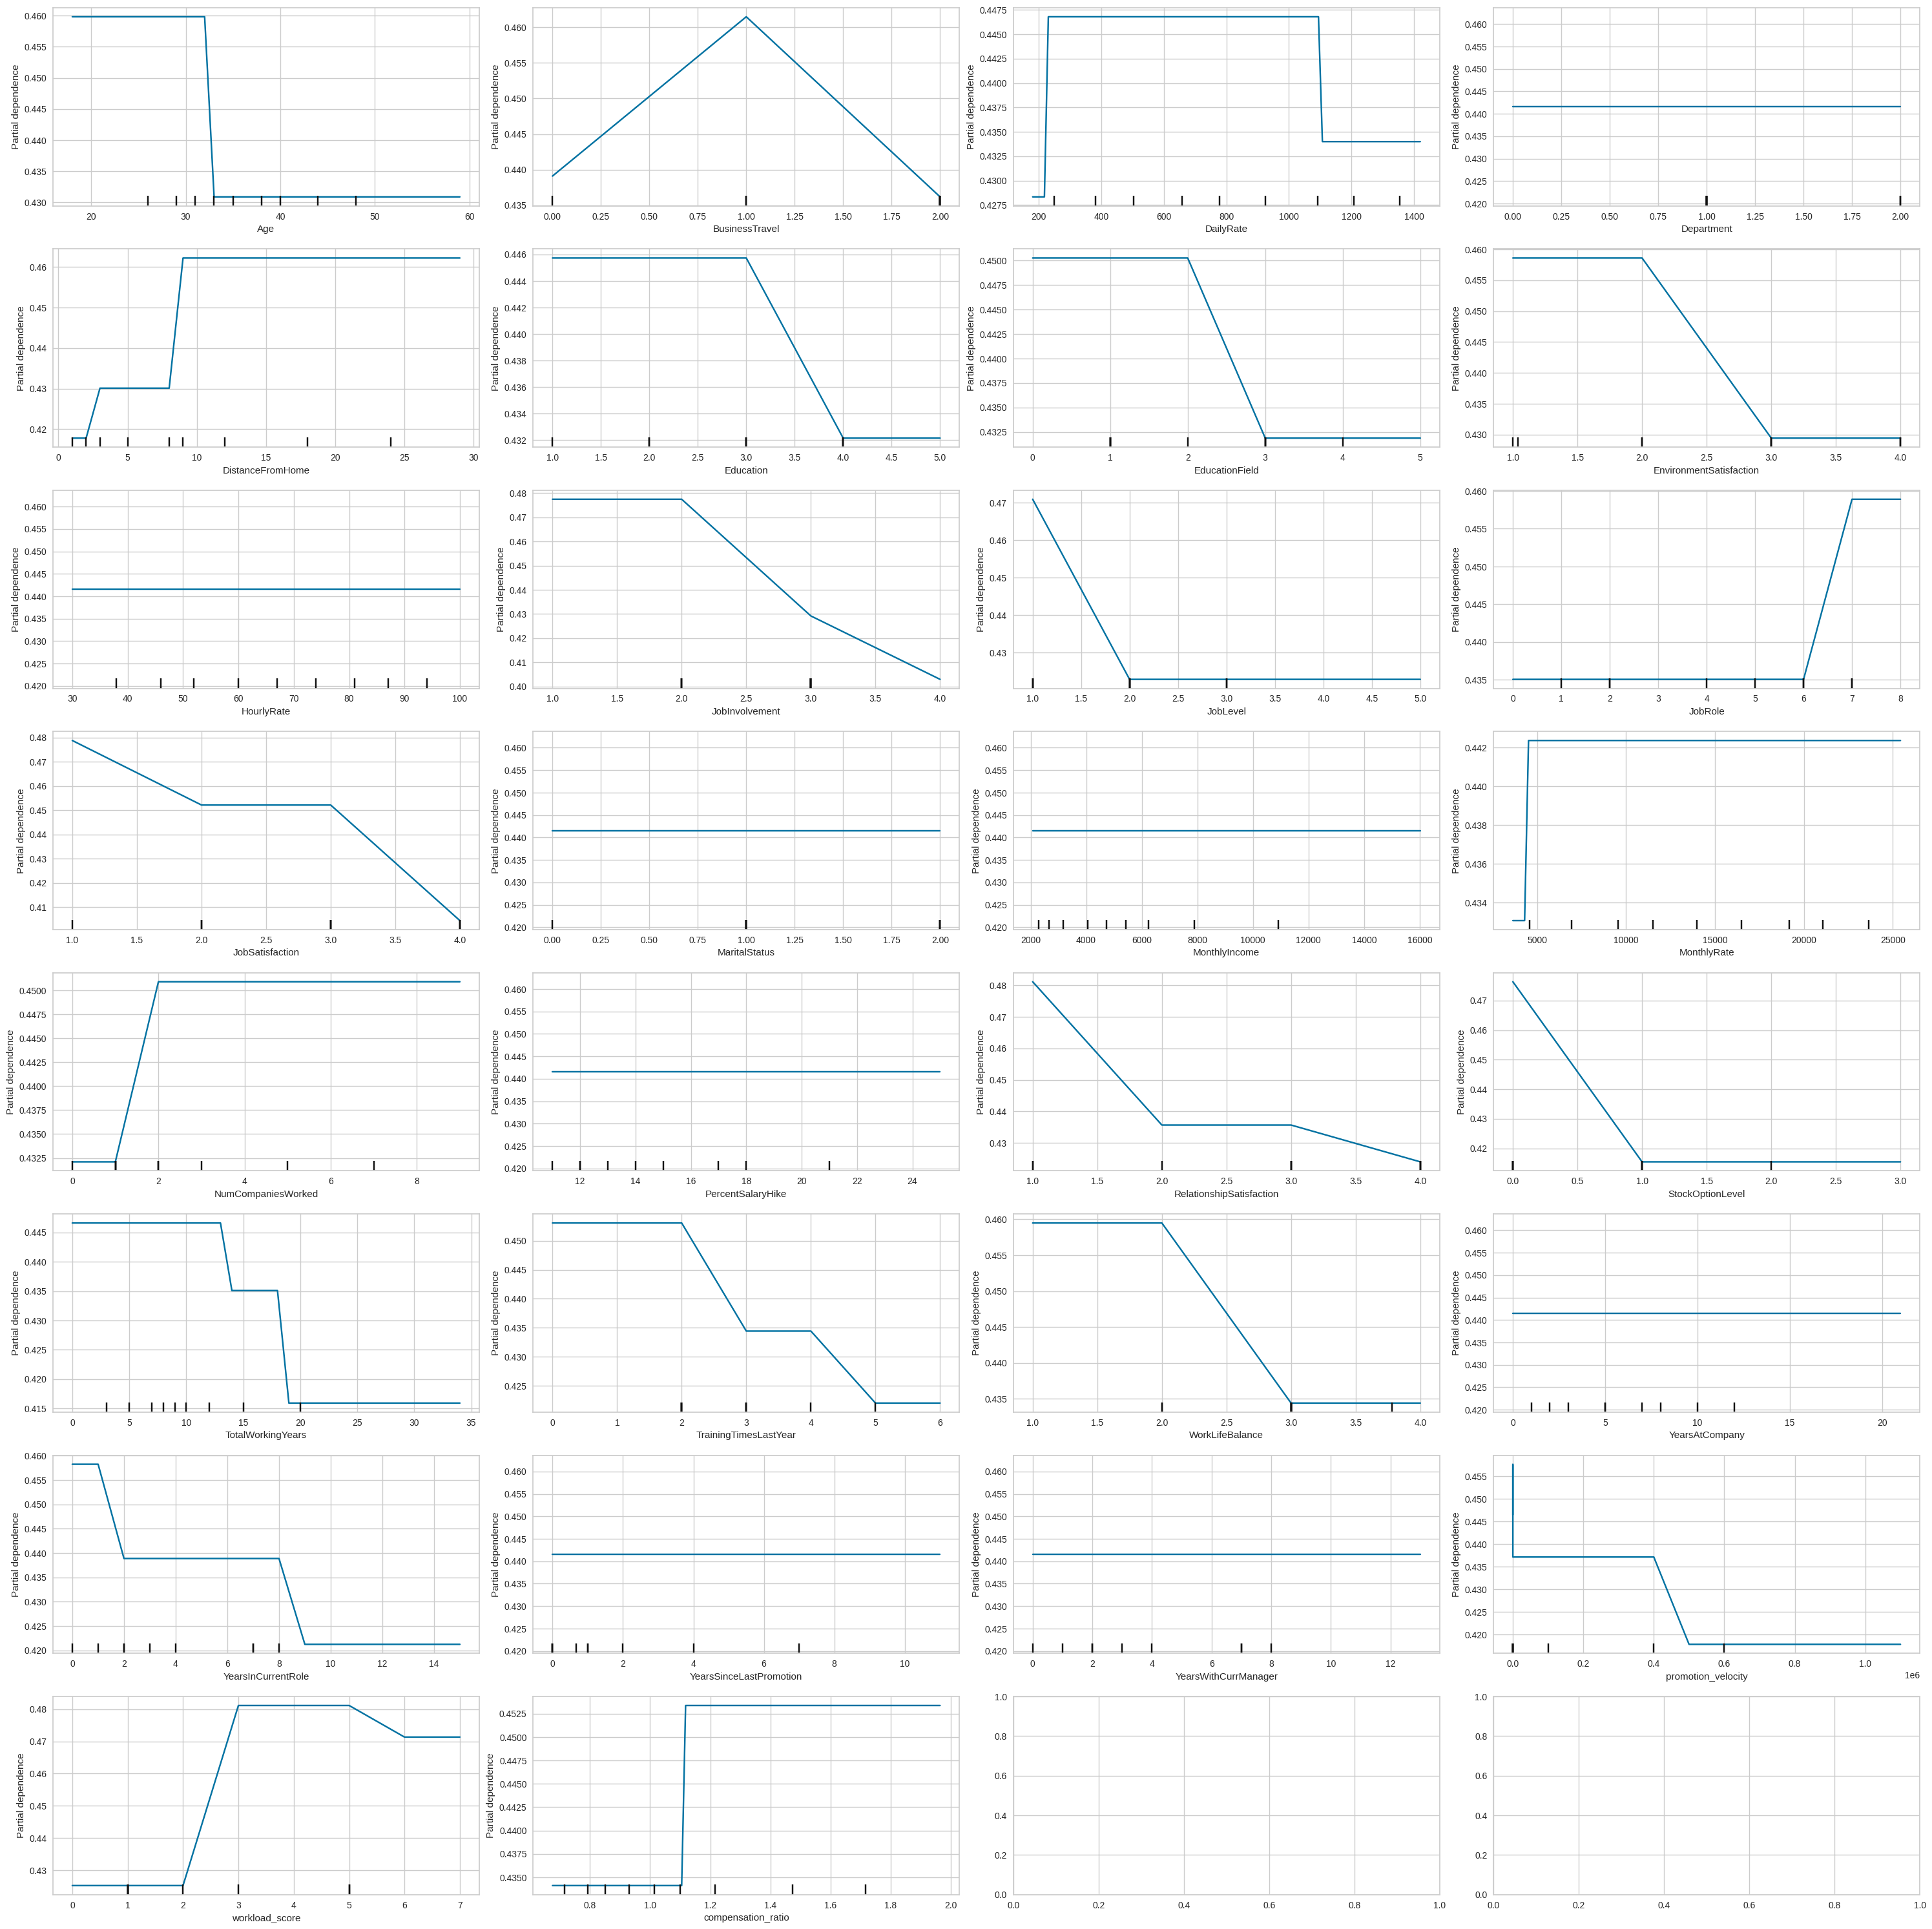

In [14]:
cols = [c for c in X_test.columns if X_test[c].nunique()>2]
nc = 4
nr = (len(cols) + nc - 1) // nc
fig, axes = plt.subplots(nr, nc, figsize=(30, 30))
for ax, feat in zip(axes.flatten(), cols):
    PartialDependenceDisplay.from_estimator(
        ada, X_test, [feat], ax=ax)
plt.tight_layout()

- Model is influenced mainly by financial ratios (int_rate, Debt_To_Income), loan amount, income, and credit grade.

- Many features have negligible or redundant contributions.

<!-- Interpretation supports possible feature pruning or simplification for explainability. -->

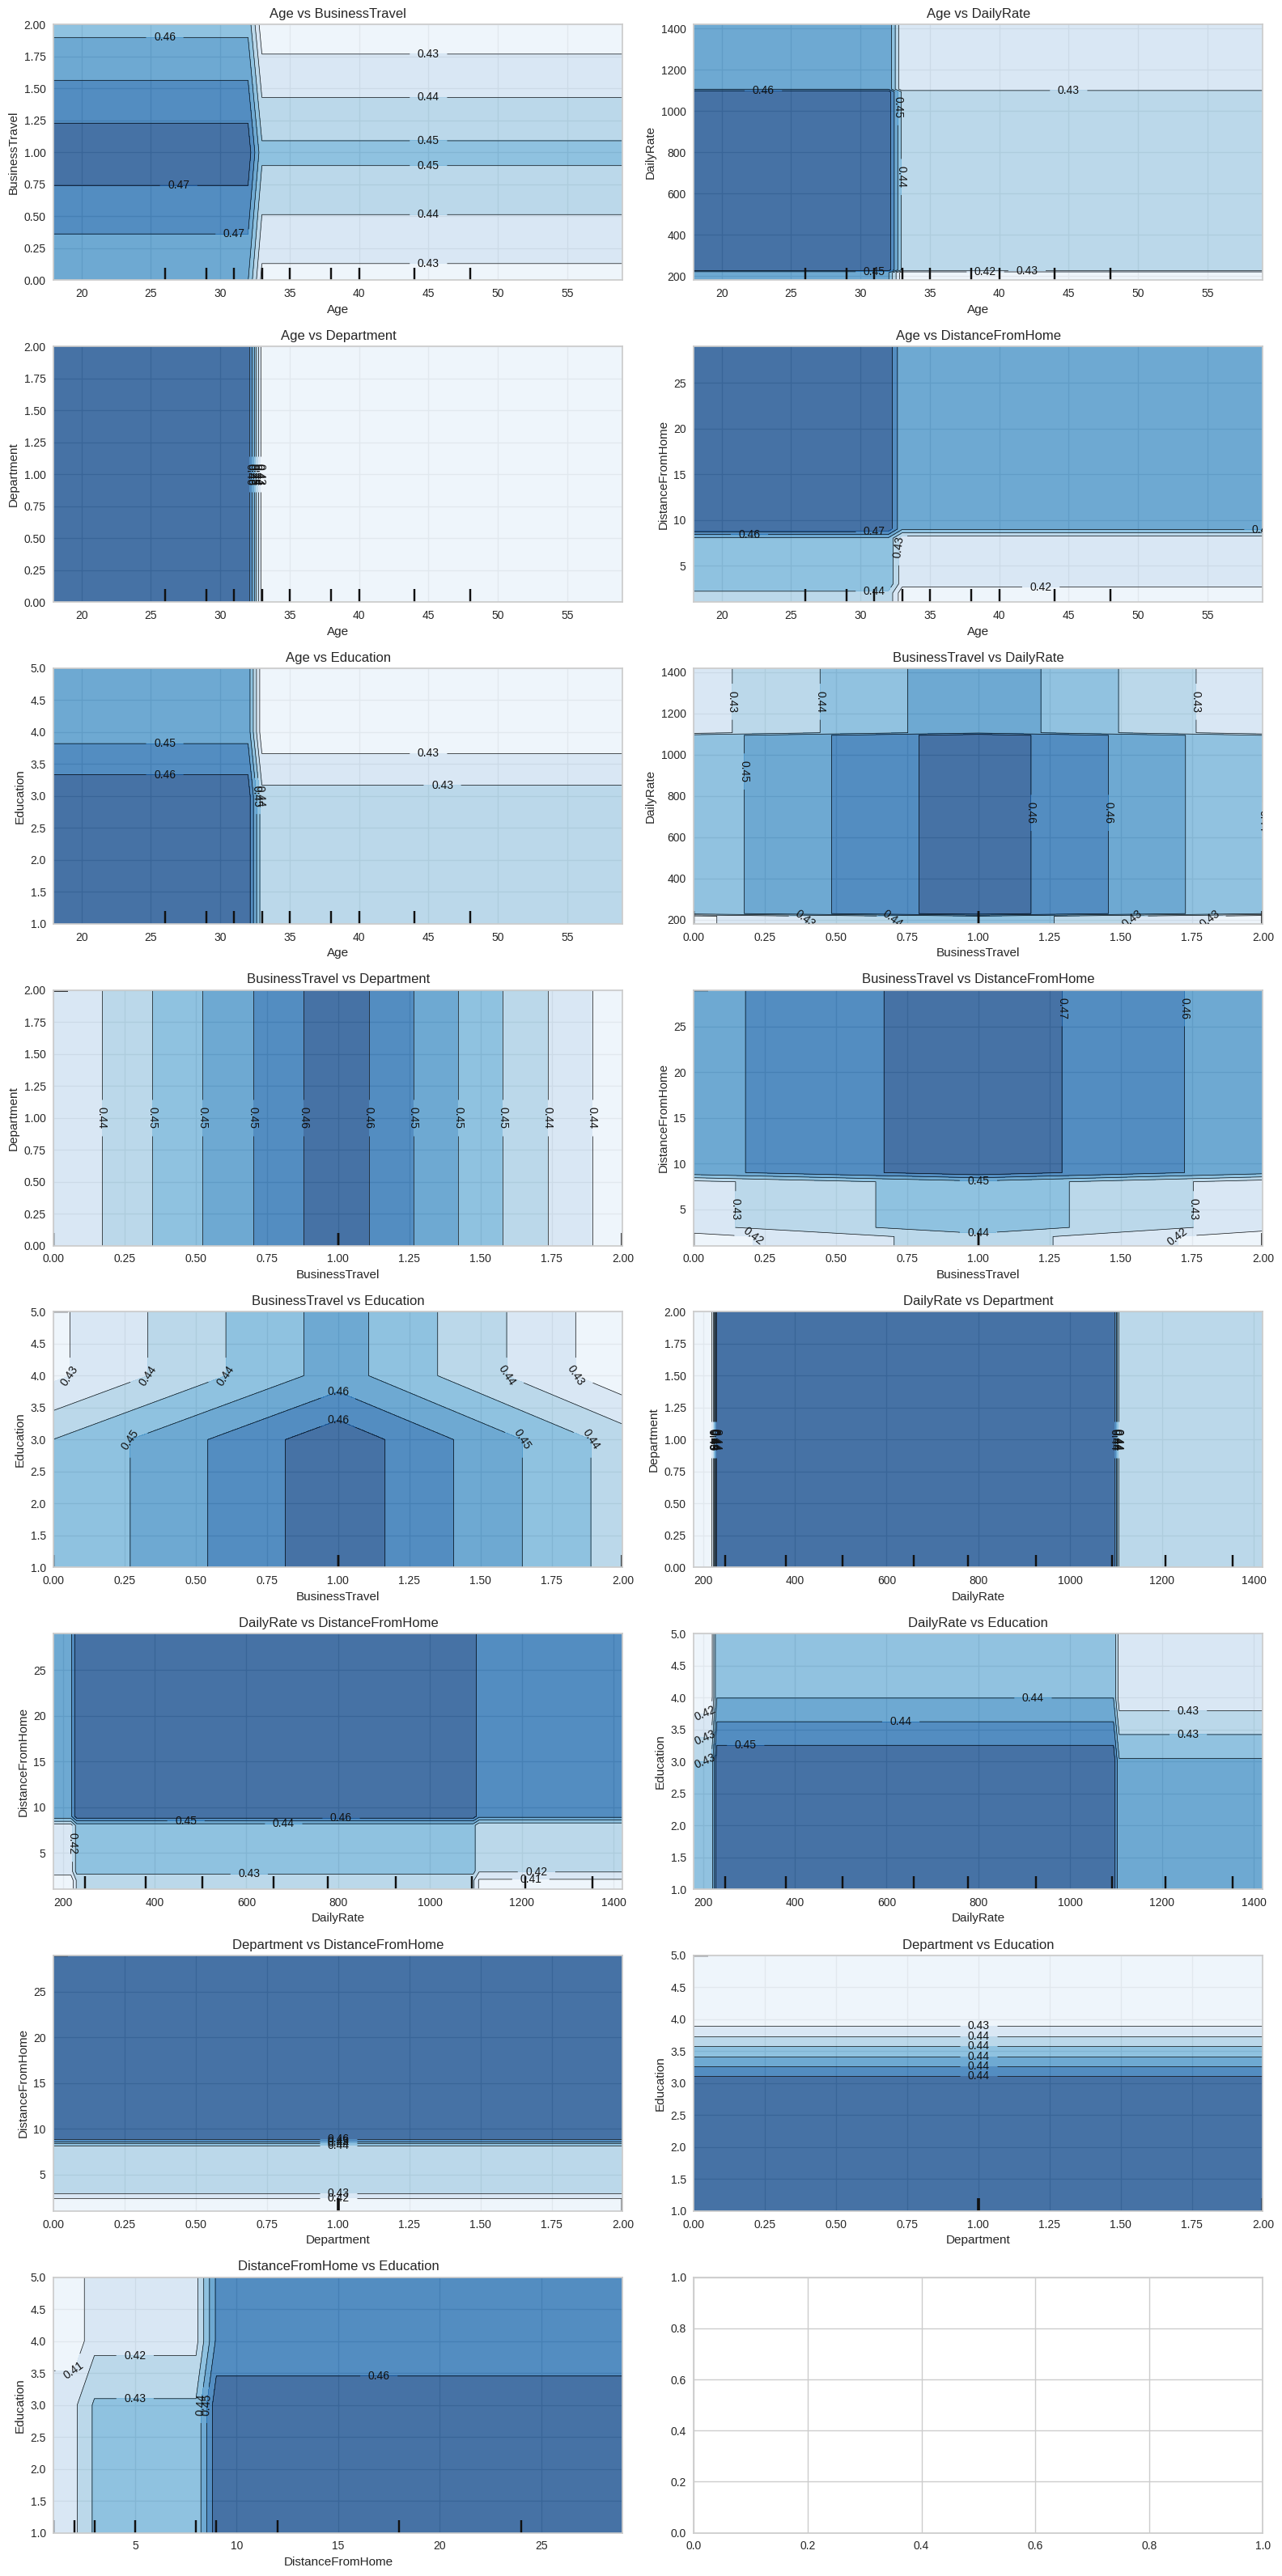

In [15]:
important_features = cols[:6]
feature_pairs = []
for i in range(len(important_features)):
    for j in range(i+1, len(important_features)):
        feature_pairs.append((important_features[i], important_features[j]))

n_pairs = len(feature_pairs)
n_cols = 2
n_rows = (n_pairs + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))

for ax, feat_pair in zip(axes.flatten(), feature_pairs):
    PartialDependenceDisplay.from_estimator(
        ada, X_test, [feat_pair], ax=ax,
        kind='average', contour_kw={'cmap': 'Blues'})
    ax.set_title(f'{feat_pair[0]} vs {feat_pair[1]}')



plt.tight_layout()

These interaction plots reveal minimal feature interactions, indicating the model’s predictions are driven primarily by individual feature contributions rather than synergies between pairs. Key observations:  


   - Most plots show flat or near-flat trends
   - Even in cases with slight variations like BusinessTravel vs Education, the impact is marginal (prediction shifts from ~0.43–0.46).  





## ICE

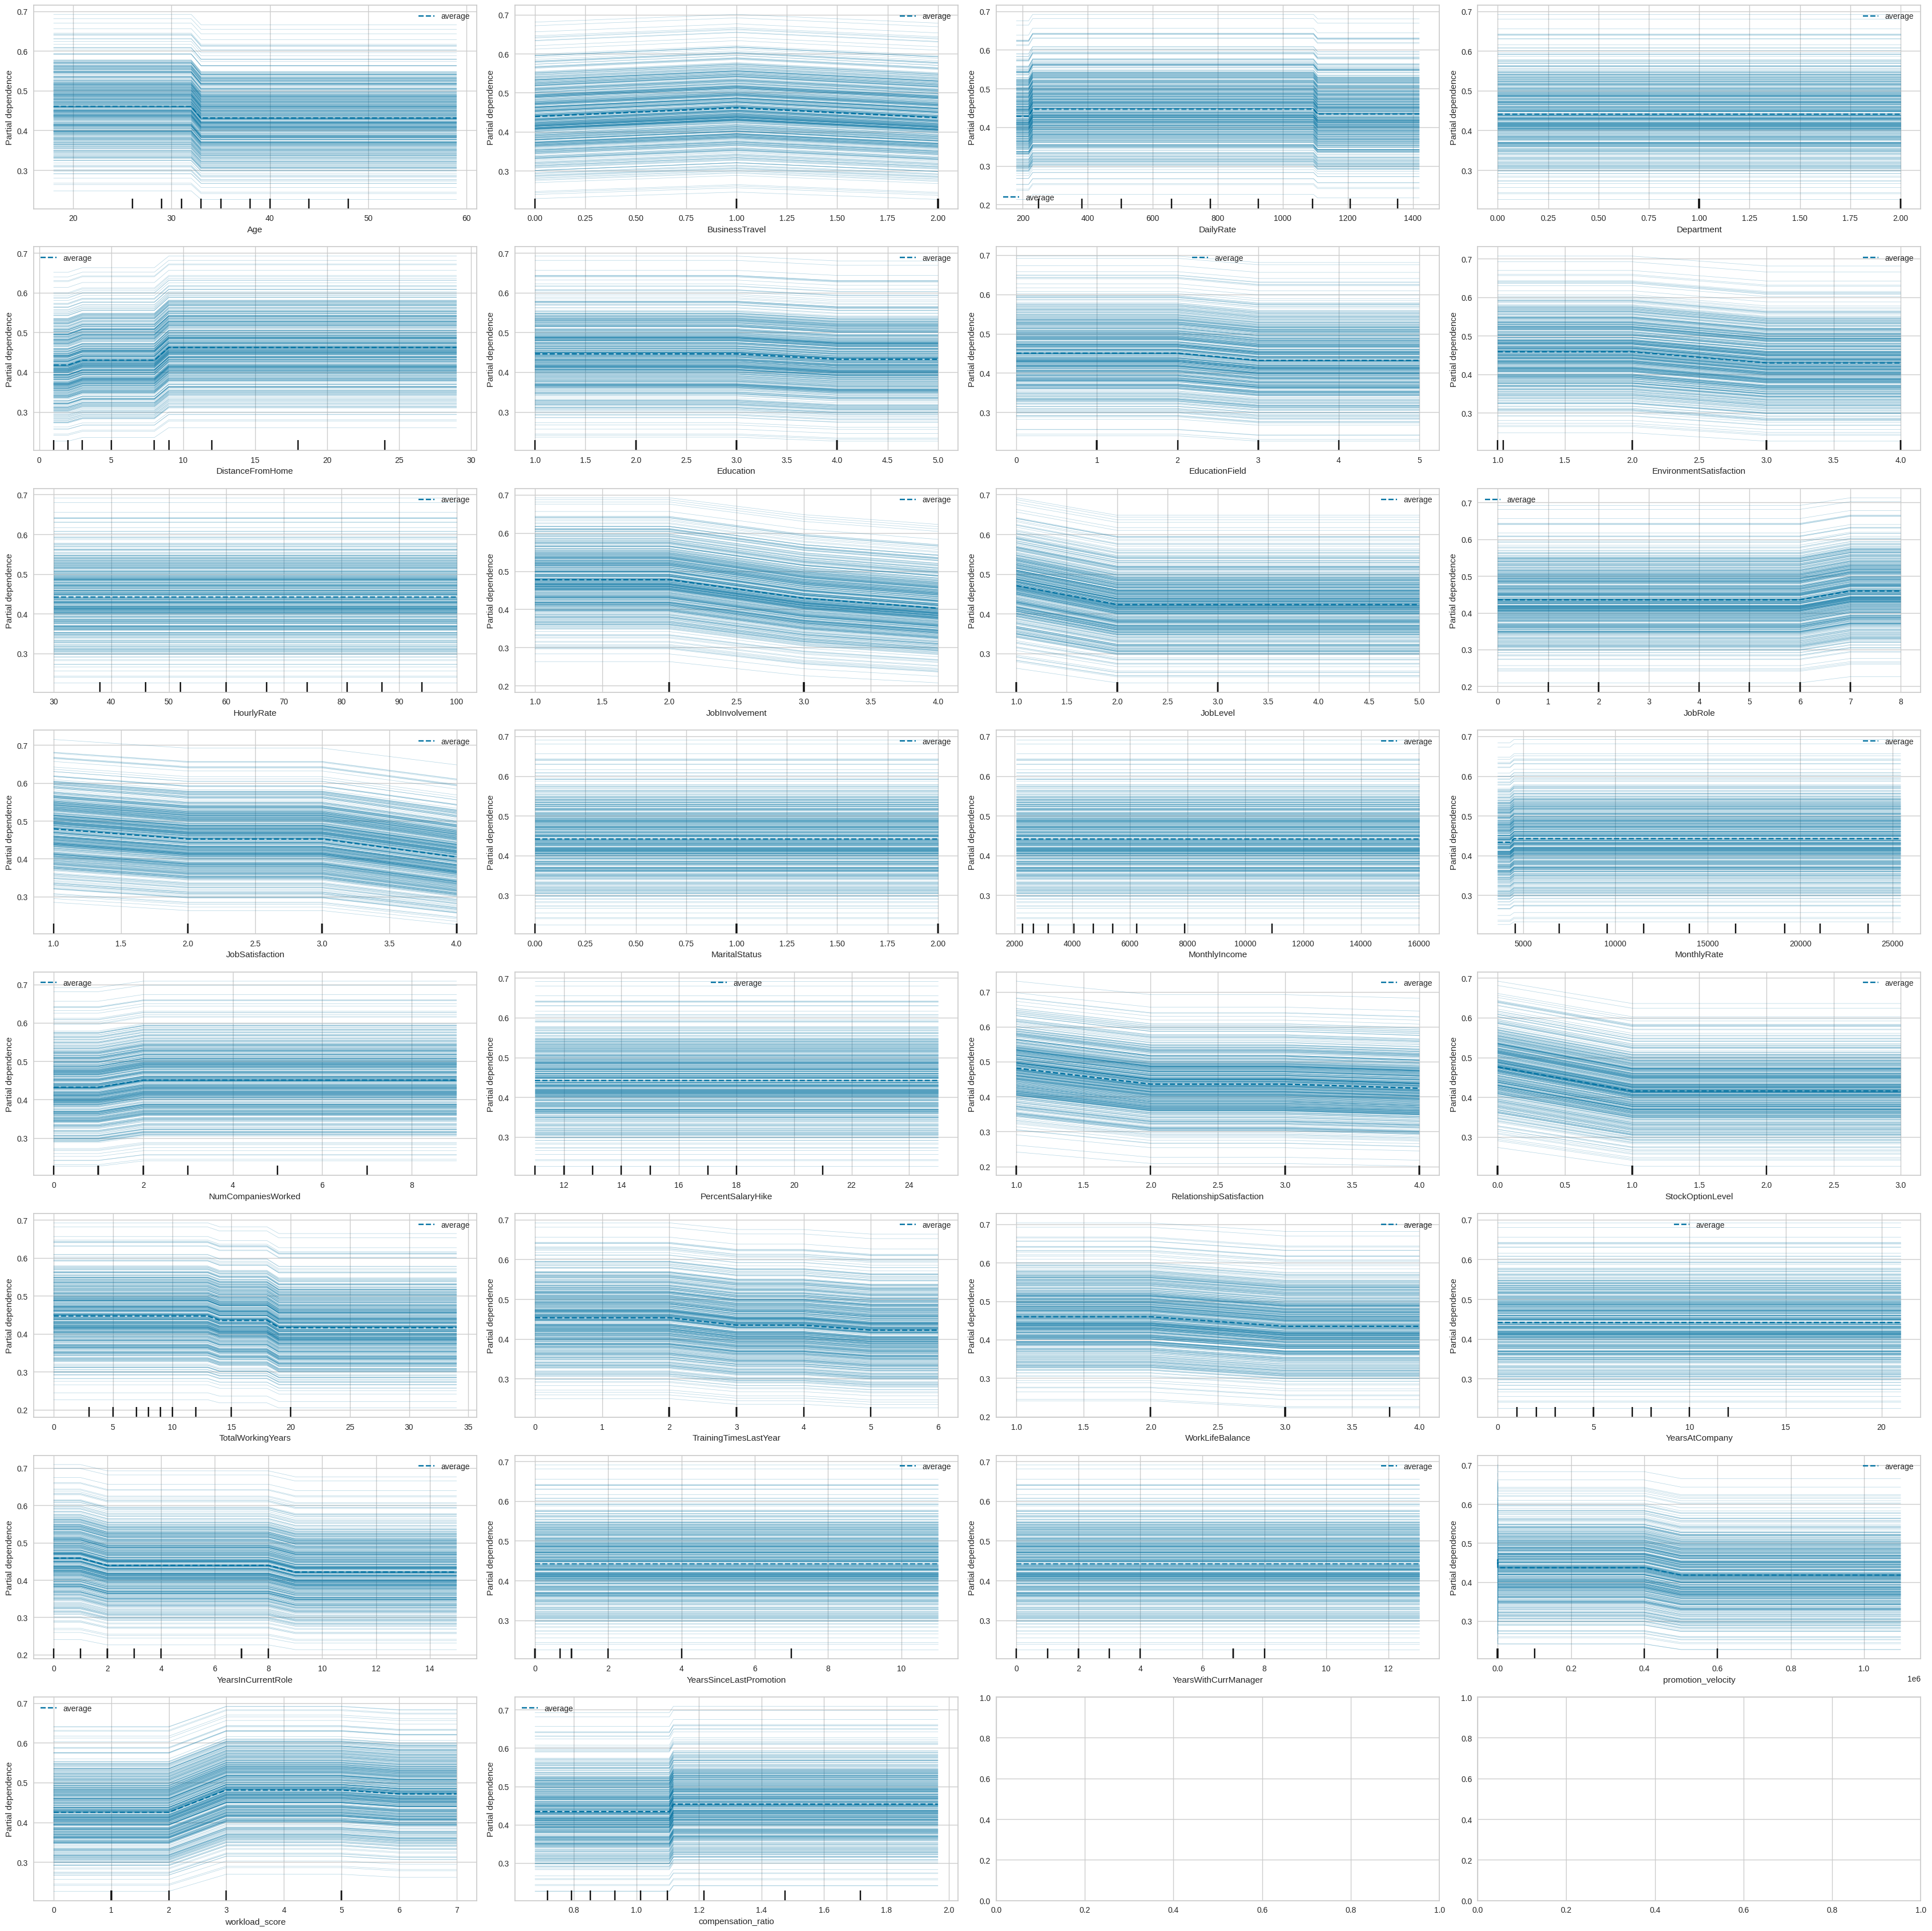

In [16]:
cols = [c for c in X_test.columns if X_test[c].nunique()>2]
nc = 4
nr = (len(cols) + nc - 1) // nc
fig, axes = plt.subplots(nr, nc, figsize=(34, 34))
for ax, feat in zip(axes.flatten(), cols):
    PartialDependenceDisplay.from_estimator(
        ada, X_test, [feat], ax=ax, kind='both')
plt.tight_layout()

Most features show negligible impact on predictions. Weak positive correlations exist for satisfaction metrics (environment, job, relationship, work-life balance) and tenure-related factors (total working years, years at company, role tenure).

Weak negative trends appear in financial metrics (daily/hourly rates, salary hike) and stock options.

Workload and compensation ratio also show slight positive links.

No meaningful influence from demographics, department, job role, or promotion velocity.


## LIME Analysis

In [17]:
from lime.lime_tabular import LimeTabularExplainer
explainer = LimeTabularExplainer(X_train.values,
                                 feature_names = list(X_train.columns),
                                 class_names = ['No Attrition', 'Attrition'])
explainer.explain_instance(X_test.values[2],
                           ada.predict_proba).show_in_notebook()

## SHAP Analysis

In [18]:
explainer = shap.KernelExplainer(ada.predict_proba, X_test[:100])
shap_values = explainer.shap_values(X_test[:100])

  0%|          | 0/100 [00:00<?, ?it/s]

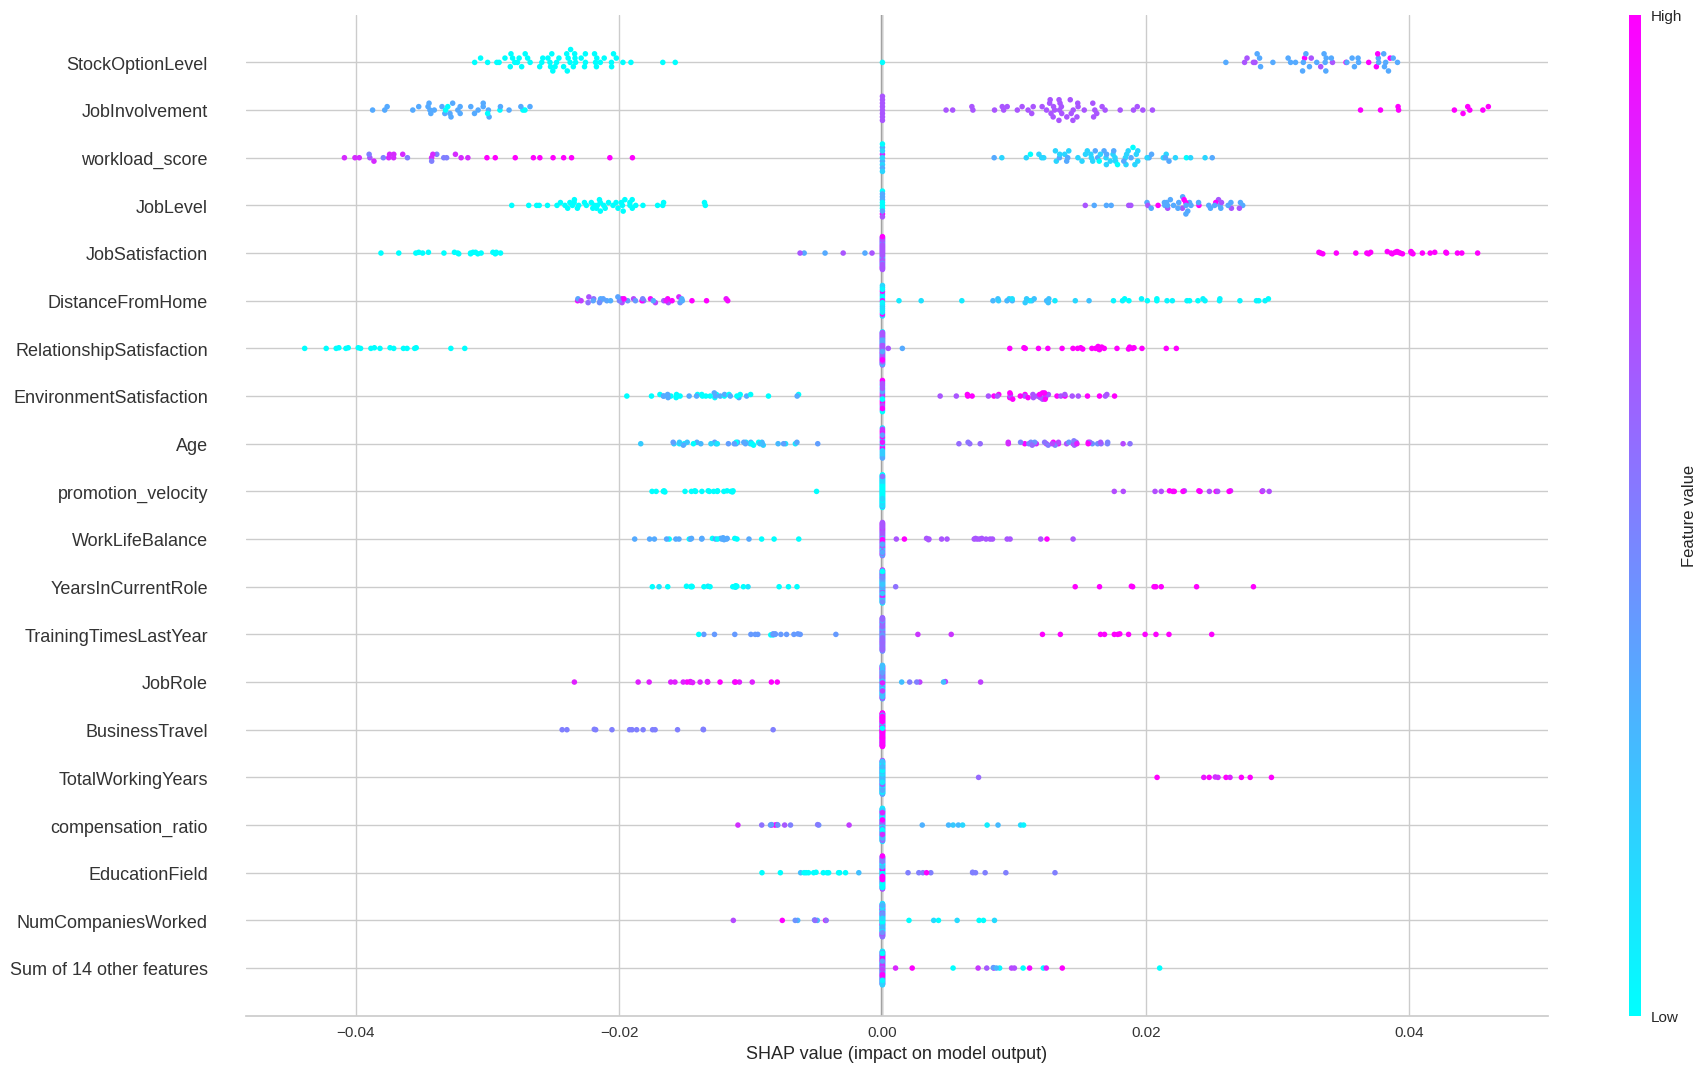

In [19]:
plots.beeswarm(
    Explanation(
        values=shap_values[:, :, 0],
        base_values=explainer.expected_value[1],
        data=X_test[:100],
        feature_names=getattr(X_test, "columns", None)
    ),
    max_display=20,
    color=plt.get_cmap("cool"),
    plot_size=(21, 13)
)

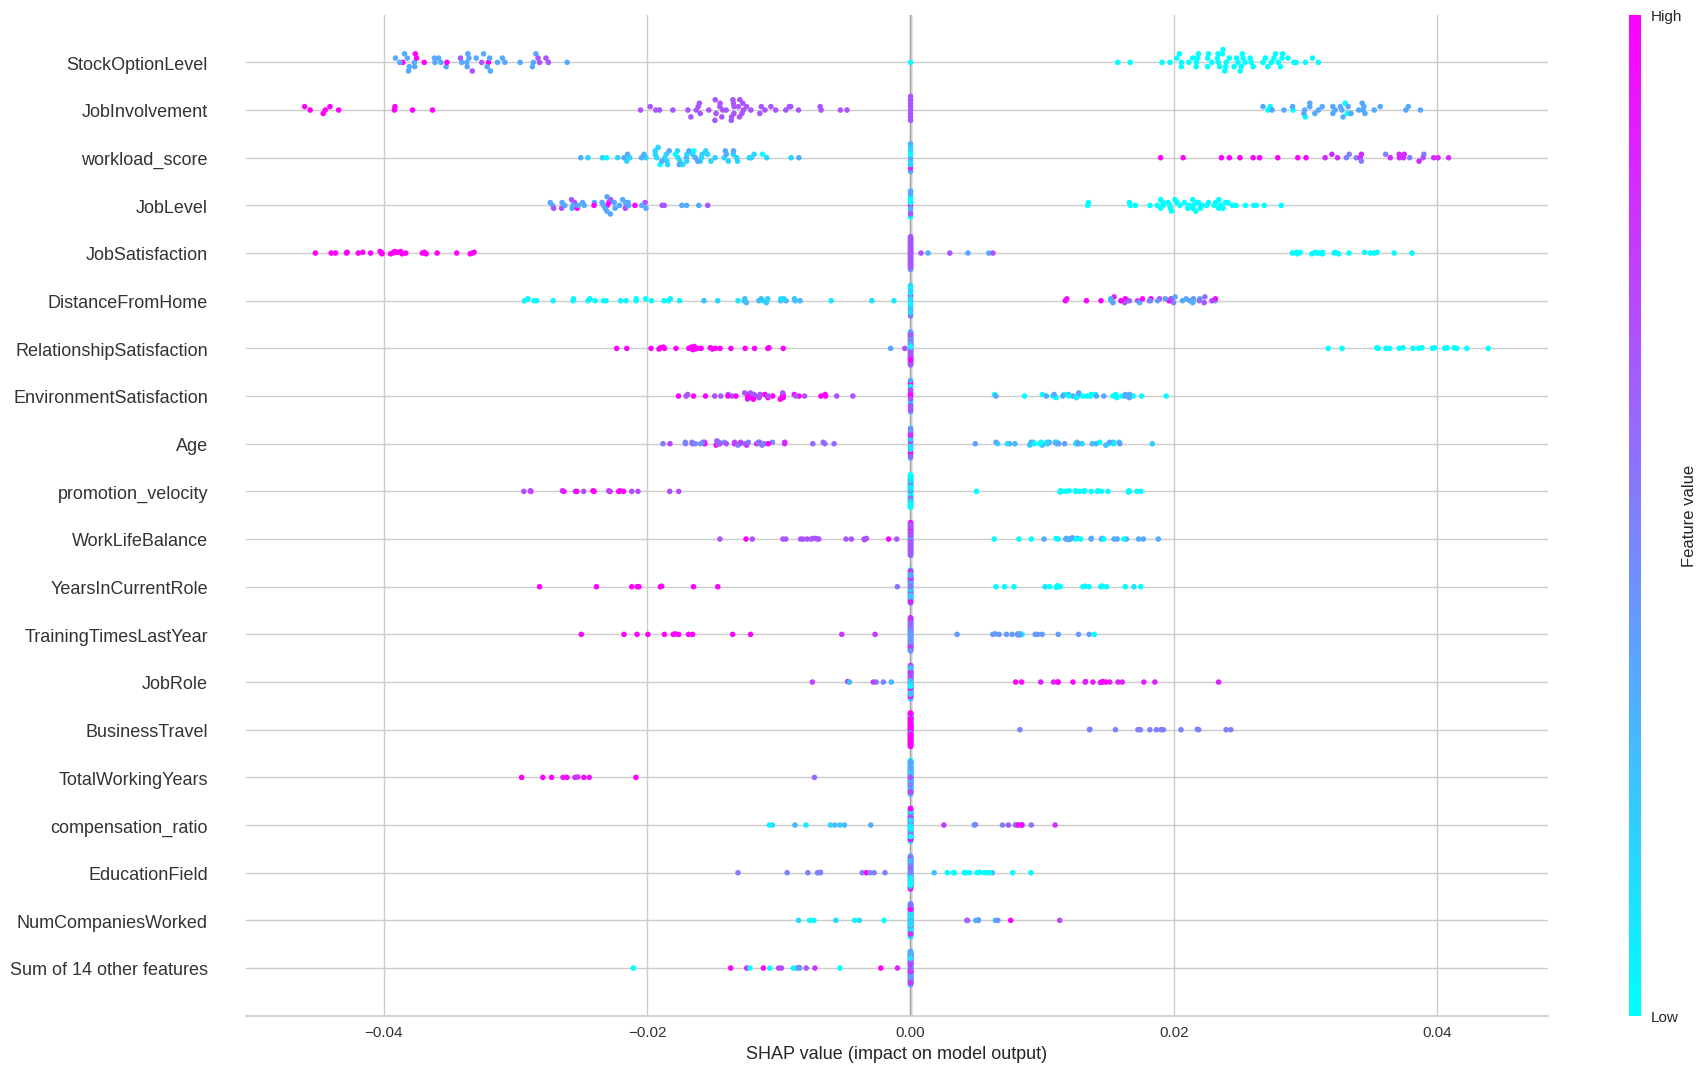

In [20]:
plots.beeswarm(
    Explanation(
        values=shap_values[:, :, 1],
        base_values=explainer.expected_value[1],
        data=X_test[:100],
        feature_names=getattr(X_test, "columns", None)
    ),
    max_display=20,
    color=plt.get_cmap("cool"),
    plot_size=(21, 13)
)

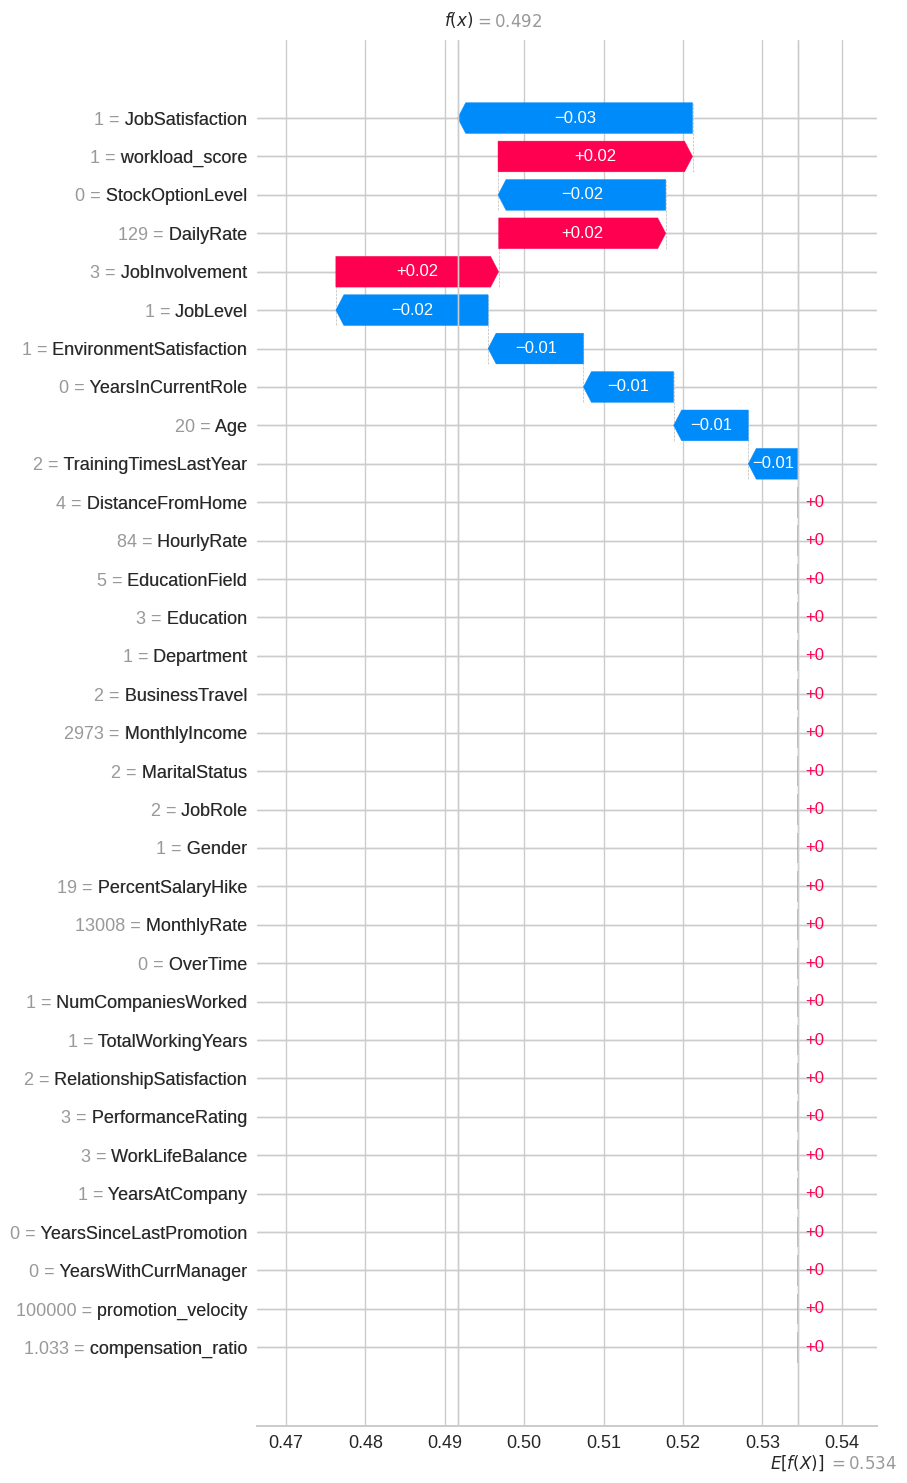

In [21]:
shap_values_exp = shap.Explanation(
    values=shap_values[0][:, 0],
    base_values=explainer.expected_value[0],
    data=X_test.iloc[0],
    feature_names=X_test.columns
)

shap.waterfall_plot(shap_values_exp, max_display=len(X_test.columns))

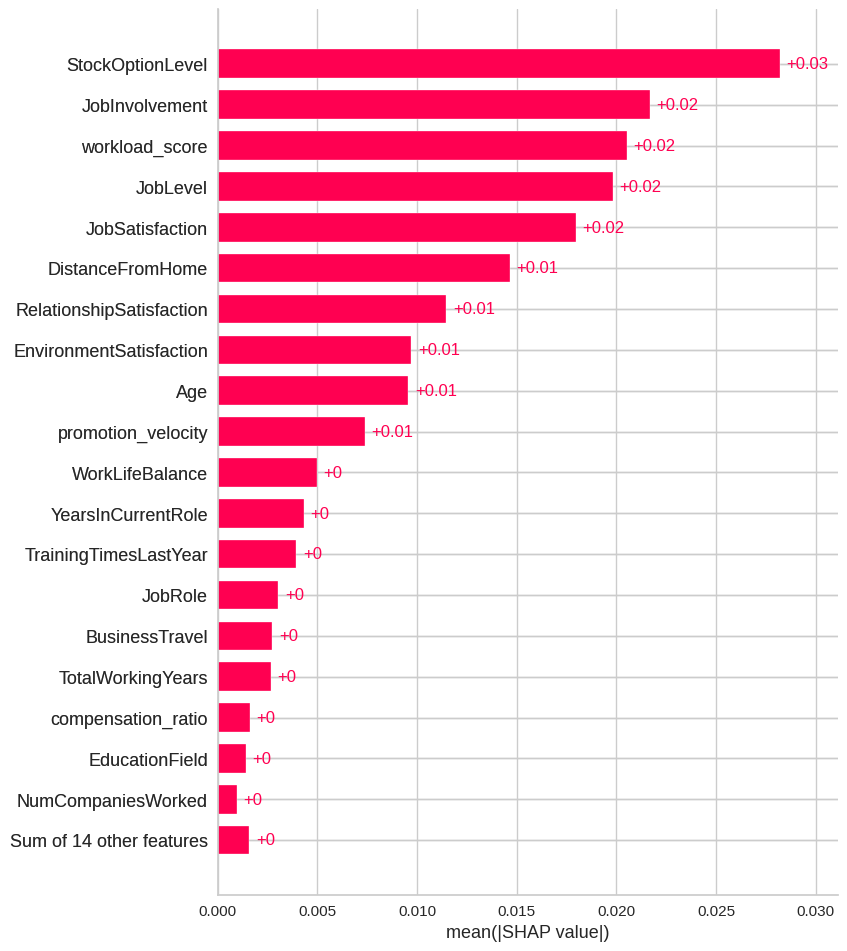

In [22]:
explanation = Explanation(
    values=shap_values[:, :, 1],
    base_values=explainer.expected_value[1],
    data=X_test.iloc[:100],
    feature_names=X_test.columns
)

shap.plots.bar(explanation, max_display=20)

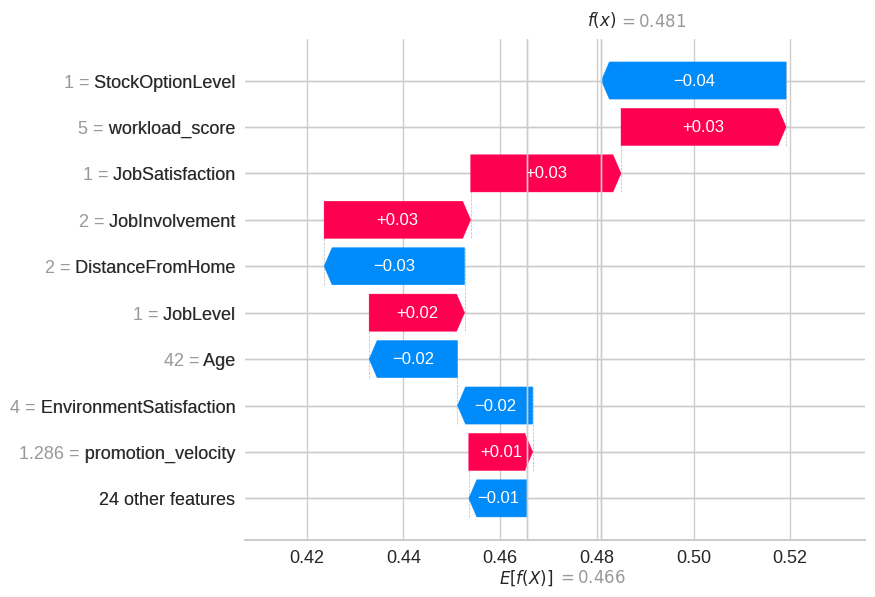

In [23]:
plots.waterfall(explanation[5])

In [24]:
shap.initjs()
plots.force(explainer.expected_value[1],
            shap_values[0, :, 1],
            features=list(X_train.columns))

In [25]:
shap.initjs()
base_value = explainer.expected_value[1]
sv = shap_values[0:100, :, 0]
X = X_test.iloc[0:100, :]
shap.plots.force(base_value, sv, X)

# Other useful visuals

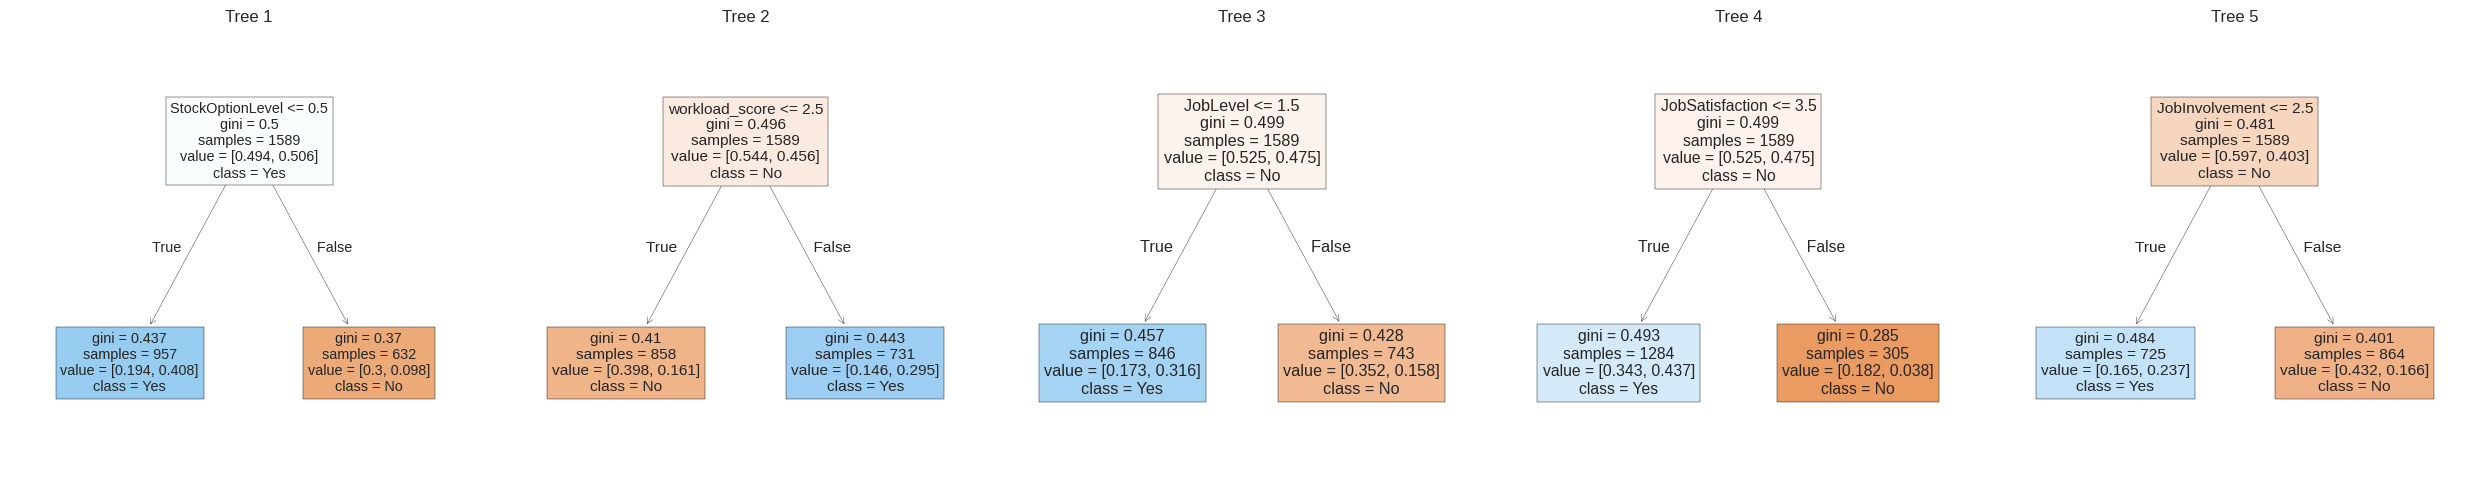

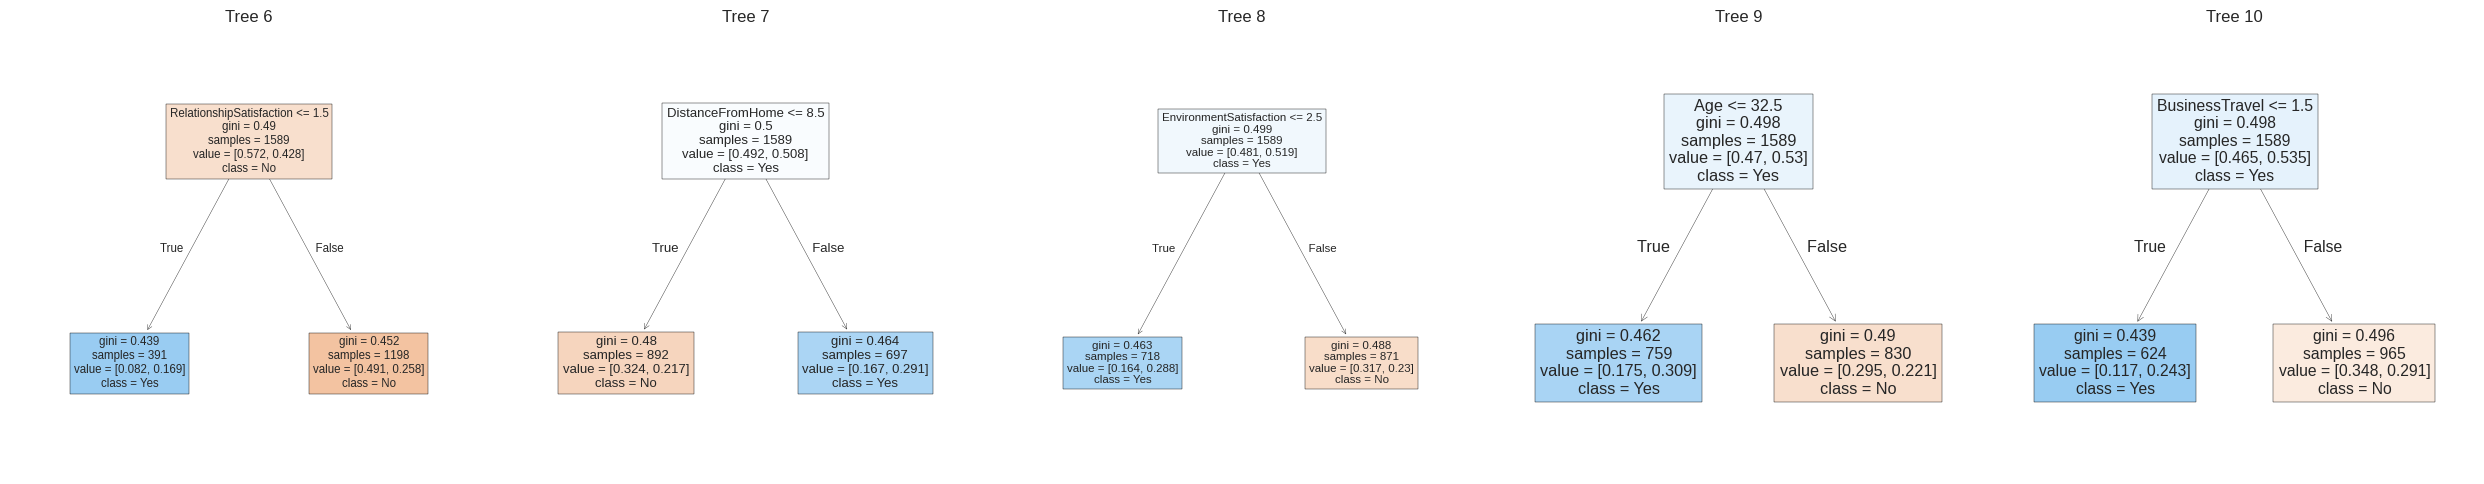

In [26]:
for i in range(0, 10, 5):
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))
    for j, ax in enumerate(axes):
        idx = i + j
        plot_tree(ada.estimators_[idx], feature_names=X_train.columns, class_names=['No', 'Yes'], filled=True, ax=ax)
        ax.set_title(f"Tree {idx+1}")

    plt.tight_layout()

Text(0.5, 1.0, 'Feature Usage Frequency (AdaBoost Trees)')

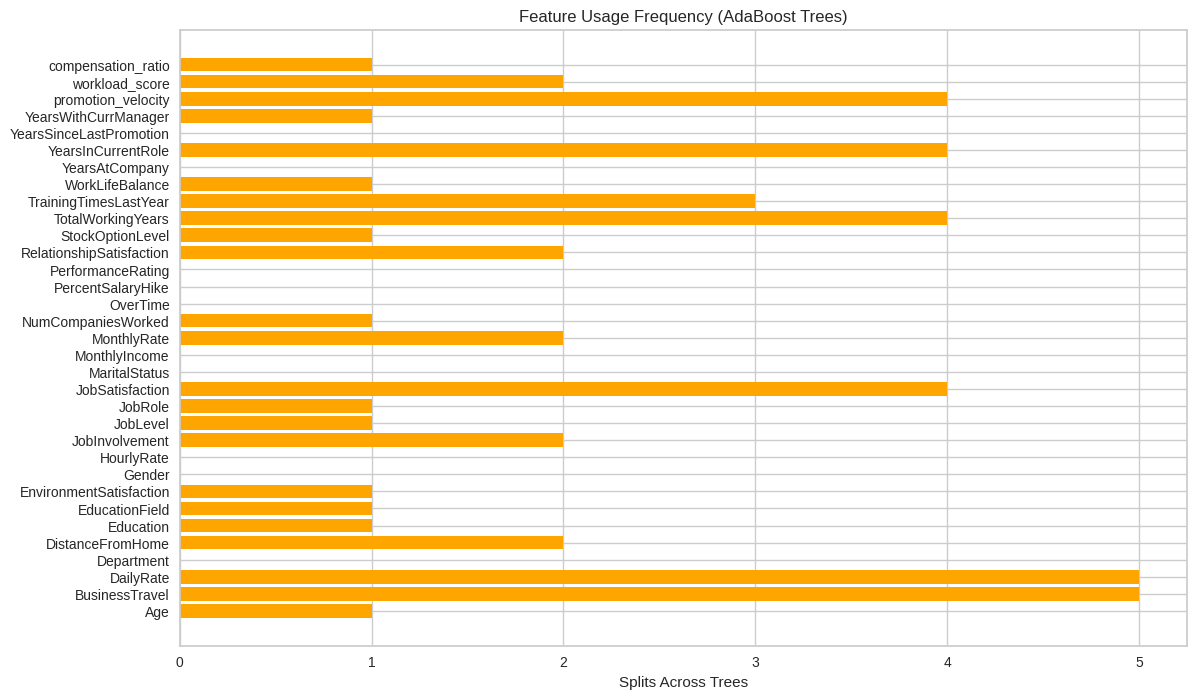

In [27]:
from collections import Counter
feature_counts = Counter()
for est in ada.estimators_:
    used = est.tree_.feature
    used = used[used >= 0]
    feature_counts.update(used)
feat_names = np.array(X_train.columns)
freq = np.array([feature_counts.get(i, 0) for i in range(len(feat_names))])
plt.figure(figsize=(13, 8))
plt.barh(feat_names, freq, color="orange")
plt.xlabel("Splits Across Trees")
plt.title("Feature Usage Frequency (AdaBoost Trees)")

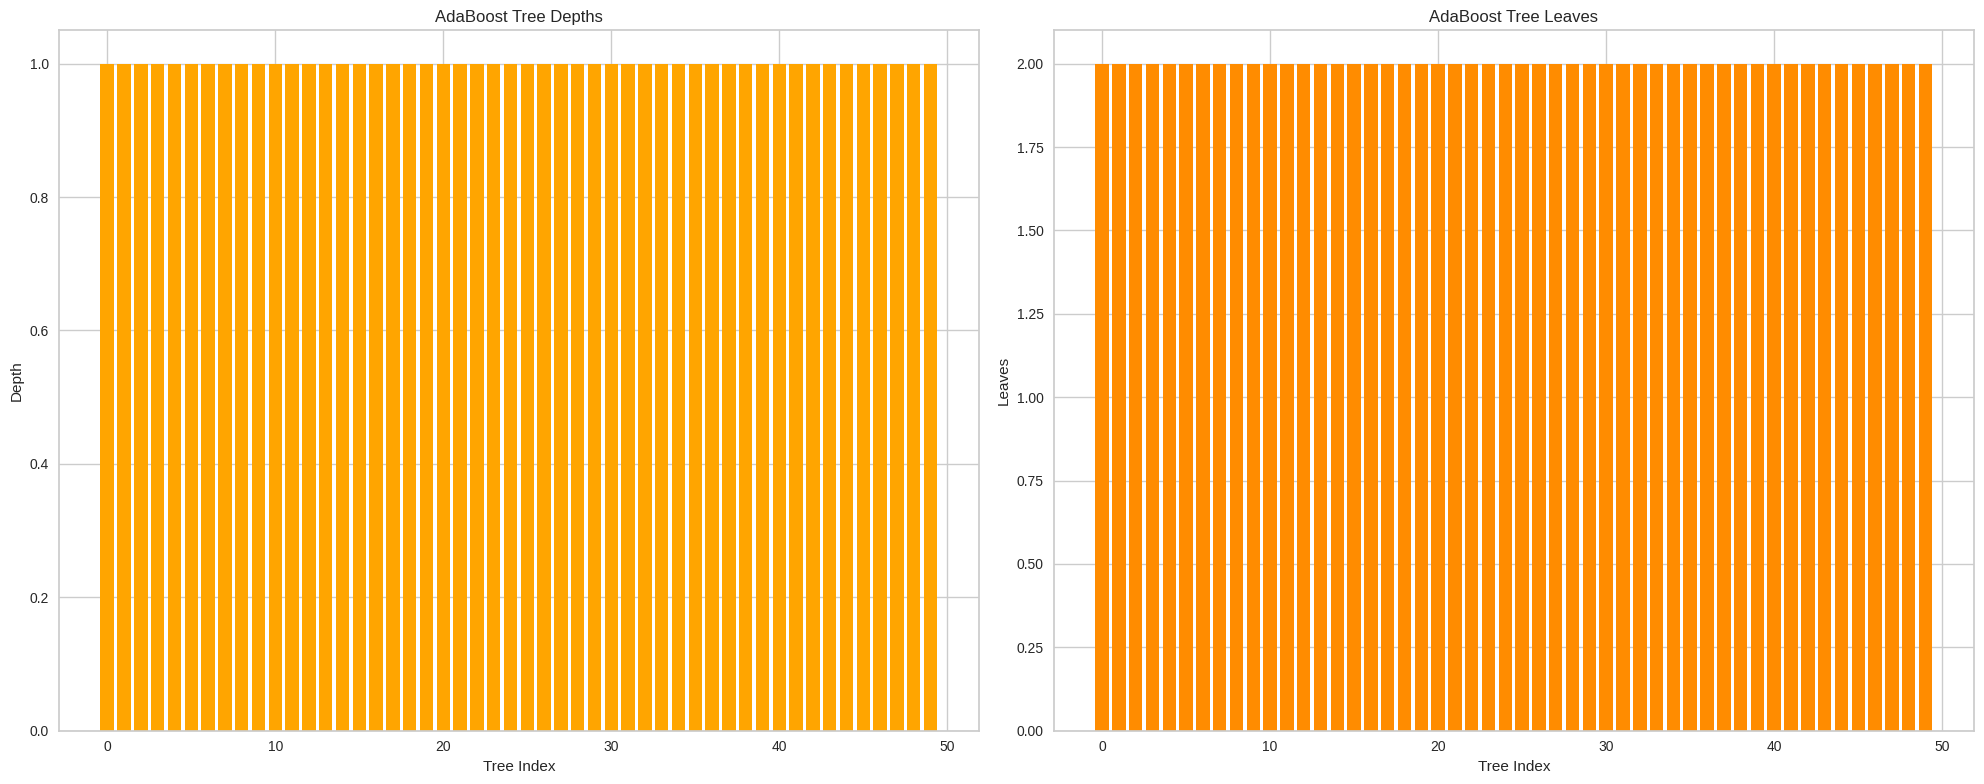

In [28]:
tree_depths = [est.tree_.max_depth for est in ada.estimators_]
tree_leaves = [est.tree_.n_leaves for est in ada.estimators_]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.bar(range(len(tree_depths)), tree_depths, color="orange")
ax1.set_title("AdaBoost Tree Depths")
ax1.set_xlabel("Tree Index")
ax1.set_ylabel("Depth")
ax2.bar(range(len(tree_leaves)), tree_leaves, color="darkorange")
ax2.set_title("AdaBoost Tree Leaves")
ax2.set_xlabel("Tree Index")
ax2.set_ylabel("Leaves")
plt.tight_layout()
plt.show()